## Data Preparation

Split the data into training and testing data

In [1]:
import pandas as pd

df = pd.read_csv("https://dlsun.github.io/pods/data/bordeaux.csv",
                 index_col="year")
df_train = df.loc[:1980].copy()
df_test = df.loc[1981:].copy()

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, metric="euclidean"))
X_train = df_train[["win", "summer"]]
y_train = df_train["price"]

Fit a 5-nearest neighbors model to the training data and use the model to predict the labels on the testing data

In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="neg_mean_squared_error",
    cv=4)
-scores.mean()

375.27166666666665

## Model Selection

What input features should we include?

- winter rain, summer temp
- winter rain, summer temp, harvest rain
- winter rain, summer temp, harvest rain, Sept. temp

In [4]:
for features in [["win", "summer"],
                 ["win", "summer", "har"],
                 ["win", "summer", "har", "sep"]]:
  scores = cross_val_score(
      pipeline,
      X=df_train[features],
      y=df_train["price"],
      scoring="neg_mean_squared_error",
      cv=4)
  print(features, -scores.mean())

['win', 'summer'] 375.27166666666665
['win', 'summer', 'har'] 363.04047619047617
['win', 'summer', 'har', 'sep'] 402.4507142857142


## Hyperparameter Tuning

What is the best value of $k$?

In [5]:
X_train = df_train[["win", "summer", "har"]]

ks, test_mses = range(1, 7), []
for k in ks:
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k, metric="euclidean"))
  scores = cross_val_score(
      pipeline, X_train, y_train,
      scoring="neg_mean_squared_error", cv=4)
  test_mses.append(-scores.mean())

Text(0, 0.5, 'Test MSE')

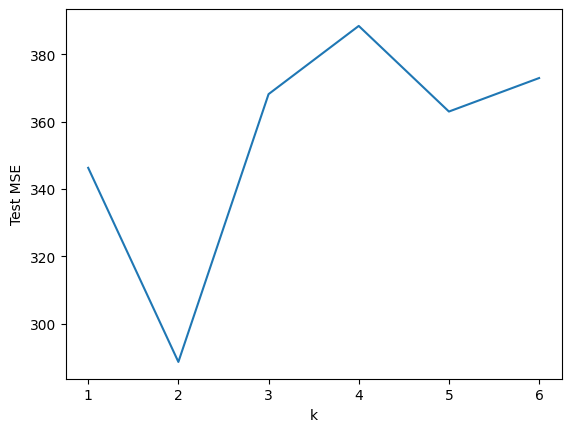

In [6]:
ax = pd.Series(test_mses, index=ks).plot.line()
ax.set_xlabel("k")
ax.set_ylabel("Test MSE")

## Grid Search

Scikit-Learn can make a grid of the possible parameter combinations, run cross-validation for each combination, and return the best parameter combination.

In [7]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(
    pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(1, 7),
        "kneighborsregressor__metric": ["euclidean", "manhattan"],
    },
    scoring="neg_mean_squared_error", cv=4)

grid_cv.fit(X_train, y_train)
grid_cv.best_params_

/Users/mac/Project/utopiq/fif/data/training/first_group/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'kneighborsregressor__metric': 'euclidean',
 'kneighborsregressor__n_neighbors': 2}

Where did the parameter names in `param_grid` come from?

In [8]:
pipeline.steps

[('standardscaler', StandardScaler()),
 ('kneighborsregressor',
  KNeighborsRegressor(metric='euclidean', n_neighbors=6))]